In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from src.data_generating_process.domainV2 import DomainGenerator, DomainParameters, RndCensoredVariables
import numpy as np 
from numpy import random as npr

def get_json(path:str):
    with open(path) as fp:
        data = json.load(fp)
    return data

def get_tuning_result(file_path:str):
    return get_json(f'{file_path}/tuning_results.json')

def get_train_log(file_path:str):
    return get_json(f'{file_path}/train_log.json')


directory = 'data/validate_dgp'
folders = sorted(os.listdir(directory))
paths = [(f'{directory}/{folder}') for folder in folders]

train_logs = []
results = []
fails = []

for folder in folders:
    try:
        results.append(get_tuning_result(f'{directory}/{folder}'))
        train_logs.append(get_train_log(f'{directory}/{folder}'))
    except:
        fails.append(folder)


data = {}
for i,(t,r) in enumerate(zip(train_logs, results)):
    if r['success']:
        data[i] = r
        data[i]['sample size']=(t['sample']['n']) *1.0
        data[i]['seed']=(t['domain']['correllation_matrix']['seed'])
        data[i]['bias']=(t['domain']['bias']['bias'])
        data[i]['exponent']=(t['domain']['transformation_exponent']['exponent'])

data = pd.DataFrame(data).T.sort_values('auc_pr').astype(float)

# only show a specified number of graphs
all_seeds = list(set(data['seed']))
seeds_15 = npr.choice(all_seeds, 16, replace=False)


# prepare dataframe for plotting and add red dots and labels
red_points = [200,2000]
space = -0.017
df = data.where(data['seed'].isin(seeds_15) )[['seed', 'sample_size', 'auc_roc']]
df.columns = ['Seed', 'Sample size', 'AUC-ROC']
df['dot_label']= np.where(df['Sample size'].isin(red_points), round(df['AUC-ROC'],2), np.NaN)
df['dot_position']= np.where(df['Sample size'].isin(red_points),df['AUC-ROC'] +space, 0)


# make the plot
sns.set_theme()

#plt.figure(figsize=(2, 4))  # Set the size of the plot
plt.gcf().set_size_inches(8, 6)

g = sns.FacetGrid(df, col='Seed', col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="Sample size", y="AUC-ROC",
    markers = '.')
g.set(xticks=[i for i in range(0,3000,500)])
g.set_titles(col_template="")

def plot_red_points(data, **kwargs):
    subset = data[(data['Sample size'] == 200) | (data['Sample size'] == 2000)]
    for _, row in subset.iterrows():
        plt.scatter(row['Sample size'], row['AUC-ROC'], color='brown')
        plt.text(row['Sample size'], row['dot_position'], f"{row['AUC-ROC']:.2f}", 
                 color='black', 
                 verticalalignment='bottom',
                 horizontalalignment = 'left')

# Apply the function to each facet
g.map_dataframe(plot_red_points)


# Save the figure as a PNG file
#plt.savefig("output.png", format="png")


17


(16, 17)

,Seed,Sample size,AUC-ROC,dot_label,dot_position
117,12062384.0,100.0,0.830792,NaN,0.000000
205,NaN,NaN,NaN,NaN,0.000000
58,12062184.0,100.0,0.860840,NaN,0.000000
174,12062584.0,100.0,0.873308,NaN,0.000000
116,12062384.0,200.0,0.864476,0.86,0.847476
...,...,...,...,...,...
459,12063484.0,2500.0,0.992158,NaN,0.000000
452,12063484.0,2200.0,0.992206,NaN,0.000000
463,12063484.0,2800.0,0.992158,NaN,0.000000
460,12063484.0,2700.0,0.992464,NaN,0.000000


<Figure size 800x600 with 0 Axes>

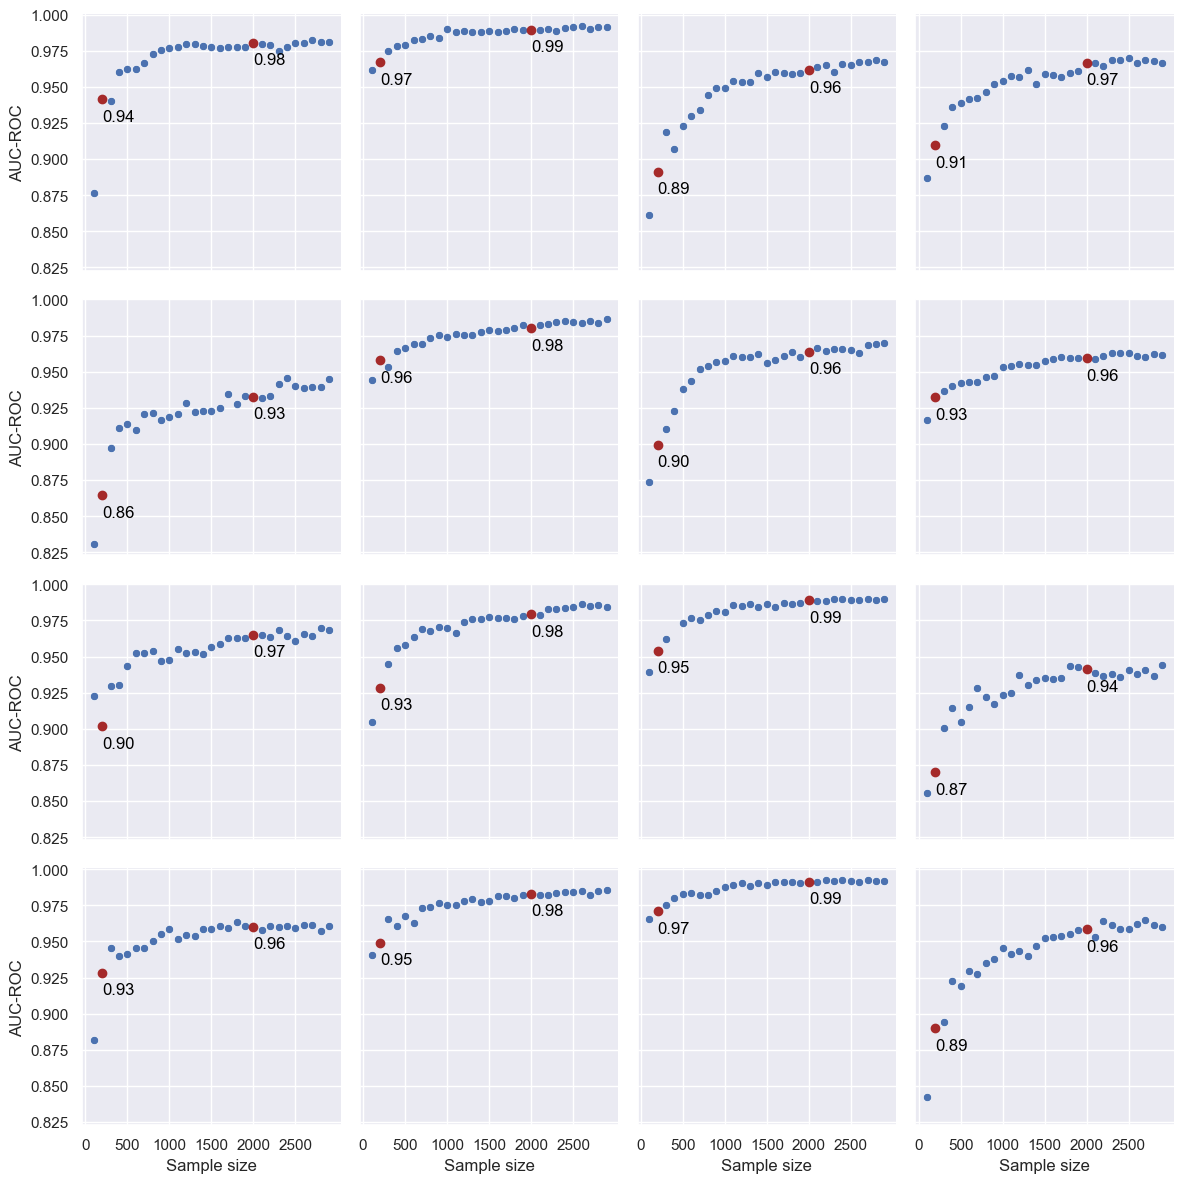

In [89]:
from pprint import pprint
failed_paths = [(f'{directory}/{folder}') for folder in fails]
failed_logs = [get_train_log(p) for p in failed_paths]
failed_domains = [{
    'domain_seed':l['domain']['base_coefficients']['seed'],
    'sample_seed':l['sample']['seed'],
    'sampel_size':l['sample']['n'],
    } for l in failed_logs] 
                  

unique_fails = list(set([d['domain_seed'] for d in failed_domains]))
unique_fails


[]

In [91]:
def get_domains(domain_seeds):
    base_coeff_cnt = 30

    domains = [
        DomainGenerator().get_domain(
            params=DomainParameters(
                base_coeff_cnt=base_coeff_cnt,
                base_coefficients_prob_of_zero=0.5,
                intr_coefficients_prob_of_zero=0.5,
                censored_variables=RndCensoredVariables(
                    censored_size=round(base_coeff_cnt * 0.2),
                    total_size=base_coeff_cnt,
                    seed=s + 1,
                ),
            ),
            seed=s,
        )
        for s in domain_seeds
    ]
    return domains

domains = get_domains(unique_fails)


